<a href="https://colab.research.google.com/github/purkutis/Samuel_INFO4670_SPRING2026/blob/main/Assignment3_AssociationRuleMining_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 — Association Rule Mining

**Dataset:** `bread_basket.csv` (11569 transactions)

Fill in the short answer cells and run the code cells. This notebook generates the required tables and figures.

**Sections:**
1. Setup & Data Load
2. EDA (a–e)
3. Frequent Itemset Mining (FP-Growth)
4. Association Rules + Report Table
5. Rule Subgraph (Bread, Coffee, Cake, Tea)
6. Interpretation Prompt


## 1) Setup & Data Load (10 pts)
- Place `bread_basket.csv` in the same folder as this notebook **or** update the path below.
- Needed packages: `pandas`, `matplotlib`, `mlxtend`, `networkx` (for the small graph).
- If a package is missing, run the `pip install` cell.

In [1]:
# write your answer here
from google.colab import files
uploaded = files.upload()

Saving bread_basket.csv to bread_basket.csv


In [2]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
# I was getting some depriciation warning so avoid that I am using the code below:
import warnings
import datetime

# This silences the specific DeprecationWarning you're seeing
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [4]:
df = pd.read_csv("bread_basket.csv")
df.head()

,transaction,item,date_time,time,period_day,weekday_weekend
0,1,Bread,30/10/2016,9:58,morning,weekend
1,2,Scandinavian,30/10/2016,10:05,morning,weekend
2,2,Scandinavian,30/10/2016,10:05,morning,weekend
3,3,Hot chocolate,30/10/2016,10:07,morning,weekend
4,3,Jam,30/10/2016,10:07,morning,weekend


## 2) EDA (a–e) (30 pts)
### a) List variables and their dtypes (5 pts)

In [6]:
# write your answer here
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   transaction      20507 non-null  int64 
 1   item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   time             20507 non-null  object
 4   period_day       20507 non-null  object
 5   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(5)
memory usage: 961.4+ KB


The dataset contains 20,507 rows and 6 columns. Each row represents a single item within a transaction. The transaction column is numeric whilst other are categorical.

### b) "Statistics" overview (5 pts)
Use `describe(include='all')` as a stand‑in for RapidMiner's Statistics. Take a screenshot when you submit.

In [7]:
# write your answer here
stat_summary = df.describe(include='all')
stat_summary

,transaction,item,date_time,time,period_day,weekday_weekend
count,20507.000000,20507,20507,20507,20507,20507
unique,NaN,94,159,1255,4,2
top,NaN,Coffee,2017-02-04,11:06,afternoon,weekday
freq,NaN,5471,292,52,11569,12807
mean,4976.202370,NaN,NaN,NaN,NaN,NaN
std,2796.203001,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN
25%,2552.000000,NaN,NaN,NaN,NaN,NaN
50%,5137.000000,NaN,NaN,NaN,NaN,NaN
75%,7357.000000,NaN,NaN,NaN,NaN,NaN


The dataset contains 20,507 records. The are 94 unique items, with Coffee being the most frequent item.

### c) Bar plot — count of **unique transactions per item** (10 pts)
Set the subtitle to your **FirstName LastName**. Take a screenshot of the figure.

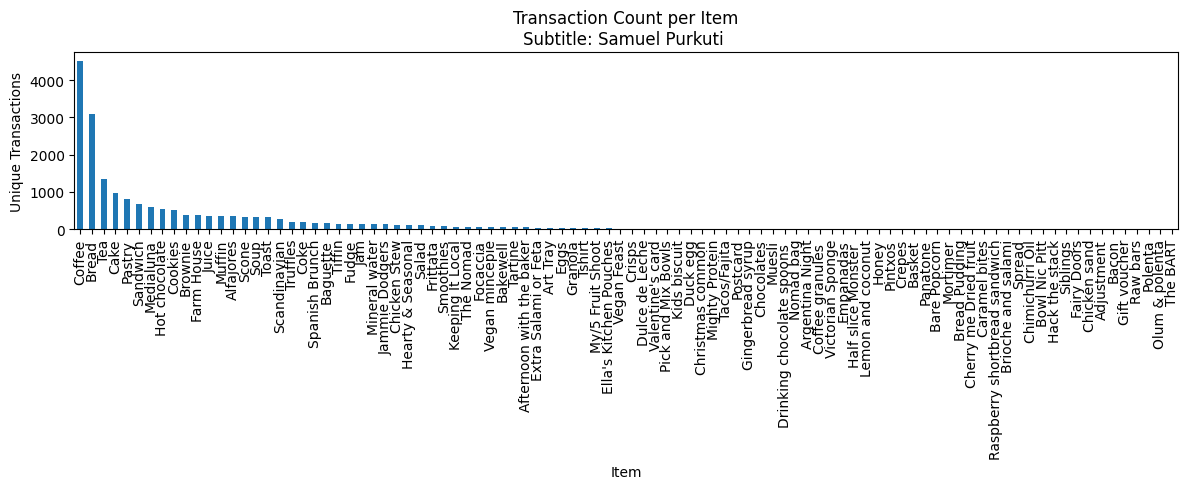

In [19]:
# c) Bar plot of transaction counts per item
subtitle = "Samuel Purkuti "

# Count unique transactions per item
item_counts = df.groupby('item')['transaction'].nunique().sort_values(ascending=False)

ax = item_counts.plot(kind='bar', figsize=(12,5))
plt.title(f"Transaction Count per Item\nSubtitle: {subtitle}")
plt.xlabel("Item"); plt.ylabel("Unique Transactions")
plt.tight_layout()
plt.show()

### d) Report counts for Coffee, Tea, Alfajores, Juice, and Chicken Stew (10 pts)

In [20]:
# write your answer here
item_to_show = ['Coffee', 'Tea', 'Alfajores', 'Juice','Chicken Stew']
filtered_df = df[df['item'].isin(item_to_show)]
filtered_df['item'].value_counts()

,count
item,
Coffee,5471
Tea,1435
Juice,369
Alfajores,369
Chicken Stew,123


## 3) Frequent Itemset Mining with FP‑Growth (min_support = 0.2) (20 pts)
We pivot the data to a **transaction × item** one‑hot table (boolean), then run FP‑Growth.

In [21]:
# write your answer here

#Grouping items by transaction to create list of lists
transactions = df.groupby('transaction')['item'].apply(list).values.tolist()

#now coverting to one-hot encoding
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
oht = pd.DataFrame(te_ary, columns=te.columns_).astype(bool)
oht.head()

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


As we see, using a minimum support of 0.2 produced not frequent itemsets due to the low frequency of item combination. So, as a next step, I set minimum support of 0.02.

In [29]:
freq_fp = fpgrowth(oht, min_support=0.02, use_colnames=True)
rules_fp = association_rules(freq_fp, metric='confidence', min_threshold=0.4) #taking 0.4 just randomly for now
rules_fp[['antecedents','consequents','support','confidence','lift']].sort_values('confidence', ascending=False)


,antecedents,consequents,support,confidence,lift
7,(Toast),(Coffee),0.023666,0.704403,1.472431
3,(Medialuna),(Coffee),0.035182,0.569231,1.189878
2,(Pastry),(Coffee),0.047544,0.552147,1.154168
4,(Juice),(Coffee),0.020602,0.534247,1.116750
6,(Sandwich),(Coffee),0.038246,0.532353,1.112792
5,(Cake),(Coffee),0.054728,0.526958,1.101515
1,(Cookies),(Coffee),0.028209,0.518447,1.083723
0,(Hot chocolate),(Coffee),0.029583,0.507246,1.060311


## 4) Association Rules + Report Table (30 pts)
(metric = confidence, min_threshold = ?) Please find a suitable min_threshold

In [14]:
# write your answer here
test_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
print(f"Threshold {0.3}: {len(test_rules)} rules found")

Threshold 0.3: 10 rules found


In [15]:
test_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)
print(f"Threshold {0.4}: {len(test_rules)} rules found")

Threshold 0.4: 8 rules found


In [16]:
test_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
print(f"Threshold {0.5}: {len(test_rules)} rules found")

Threshold 0.5: 8 rules found


In [17]:
test_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
print(f"Threshold {0.6}: {len(test_rules)} rules found")

Threshold 0.6: 1 rules found


I tried multiple thresholds and while 0.3 p.rovided with 10 rules 0.6 was too restrictive with only 1 rule. I feel 0.4 does the work with the balance of 8 rules. This does capture hight association while leaving some space for some random conincidences.

In [18]:
# 2. Generate the rules
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.4).sort_values('confidence', ascending=False)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
7,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,1.0,0.007593,1.764582,0.332006,0.048464,0.433293,0.376936
3,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,1.0,0.005614,1.210871,0.170091,0.069665,0.174148,0.321387
2,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,1.0,0.006351,1.164682,0.146161,0.091968,0.141396,0.325764
4,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247,1.116750,1.0,0.002154,1.119919,0.108738,0.041507,0.107078,0.288656
6,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353,1.112792,1.0,0.003877,1.115384,0.109205,0.074701,0.103448,0.306150


## 5) Interpretation (10 pts)
**Interpret the rule `{Coffee, Cake} ⇒ {Bread}` in plain English.**

- **Support**: What fraction of *all* transactions contain Coffee, Cake, and Bread together?
- **Confidence**: Among baskets with Coffee and Cake, what share also include Bread?
- **Lift > 1** implies positive association; comment on practical meaning.

*Your notes:*
The rule presented explains that when a customer buys coffee and cake they are likely to purchase a bread as well.

Support shows what is the share of this itemset present in the whole transactions present in the records. In plain words it presents the popularity.

Confidence is that how common is the purchase of bread when coffee and cake are purchased together.

Lastly, the lift greater than 1 explains that they aren't mutually exclusive events but the purchase of coffee and cake with bread is somehow dependent providing an opportunity of cross promotion for the business.


>